In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

folder_path = "D:/machine_learning/DeepL/Lab/data/Plant/train"

data = []

# 遍历每个子文件夹
for root, dirs, files in os.walk(folder_path):
    if dirs:
        for dir in dirs:
            subfolder_path = os.path.join(root, dir)
            file_count = len(os.listdir(subfolder_path))
            data.append([dir, file_count])

# 将数据转换为DataFrame
df = pd.DataFrame(data, columns=['Subfolder', 'File Count'])
df

,Subfolder,File Count
0,Black-grass,263
1,Charlock,390
2,Cleavers,287
3,Common Chickweed,611
4,Common wheat,221
5,Fat Hen,475
6,Loose Silky-bent,654
7,Maize,221
8,Scentless Mayweed,516
9,Shepherds Purse,231


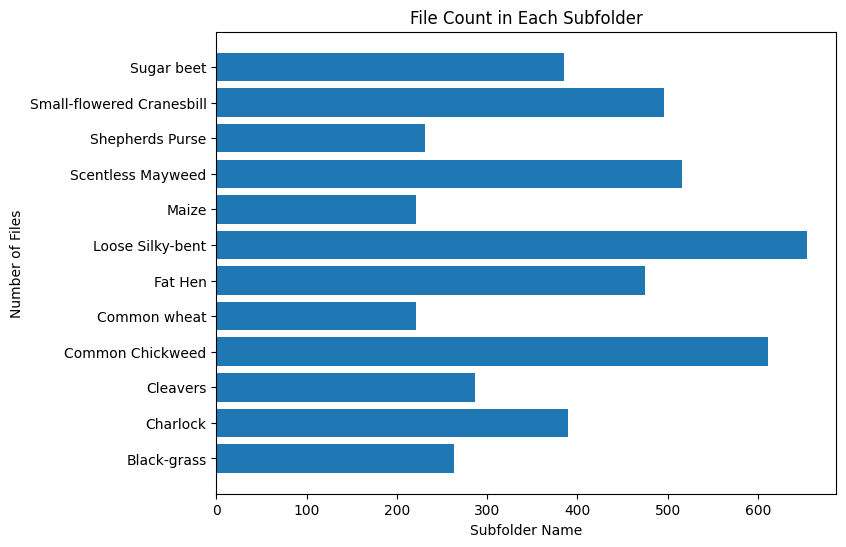

In [3]:
# 绘制条形图
plt.figure(figsize=(8, 6))
plt.barh(df['Subfolder'], df['File Count'])
plt.xlabel('Subfolder Name')
plt.ylabel('Number of Files')
plt.title('File Count in Each Subfolder')
plt.xticks(rotation=0)
plt.show()

In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler


# 配置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据预处理与增强
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# 加载数据集并划分为训练集和验证集
data_dir = "D:/machine_learning/DeepL/Lab/data/Plant/train"
dataset = datasets.ImageFolder(data_dir, transform=data_transforms["train"])

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 定义模型（使用预训练的 ResNet18 作为基础模型）
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 12)  # 12 个类别
model = model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)  # 每3个epoch降低学习率
losses = []
acces = []
val_ls= []
val_acc= []
# 训练模型
def train_model_01(model, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
        scheduler.step()
        
        epoch_loss = running_loss / train_size
        epoch_acc = correct / total
        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
        losses.append(epoch_loss)
        acces.append(epoch_acc)

In [8]:
def train_model(model, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        # 训练模式
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # 训练集
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        # 验证模式
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():  # 在验证时不计算梯度
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        scheduler.step()  # 更新学习率

        # 计算训练集和验证集的损失和准确率
        epoch_train_loss = running_loss / train_size
        epoch_train_acc = correct / total
        epoch_val_loss = val_loss / val_size
        epoch_val_acc = val_correct / val_total

        print(f'Epoch {epoch}/{num_epochs - 1}, '
              f'Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_acc:.4f}')
        
        losses.append(epoch_train_loss)
        acces.append(epoch_train_acc)
        val_ls.append(epoch_val_loss)
        val_acc.append(epoch_val_acc)

train_model(model, criterion, optimizer, num_epochs=50)

Epoch 0/49, Train Loss: 1.0851, Train Accuracy: 0.6326, Val Loss: 0.8226, Val Accuracy: 0.7316
Epoch 1/49, Train Loss: 0.7419, Train Accuracy: 0.7553, Val Loss: 0.7572, Val Accuracy: 0.7295
Epoch 2/49, Train Loss: 0.5885, Train Accuracy: 0.8039, Val Loss: 0.8376, Val Accuracy: 0.7316
Epoch 3/49, Train Loss: 0.4160, Train Accuracy: 0.8576, Val Loss: 0.3207, Val Accuracy: 0.8916
Epoch 4/49, Train Loss: 0.3261, Train Accuracy: 0.8916, Val Loss: 0.2951, Val Accuracy: 0.9042
Epoch 5/49, Train Loss: 0.3027, Train Accuracy: 0.8955, Val Loss: 0.2638, Val Accuracy: 0.9137
Epoch 6/49, Train Loss: 0.2840, Train Accuracy: 0.9066, Val Loss: 0.2483, Val Accuracy: 0.9179
Epoch 7/49, Train Loss: 0.2867, Train Accuracy: 0.9087, Val Loss: 0.2587, Val Accuracy: 0.9189
Epoch 8/49, Train Loss: 0.2650, Train Accuracy: 0.9103, Val Loss: 0.2609, Val Accuracy: 0.9147
Epoch 9/49, Train Loss: 0.2626, Train Accuracy: 0.9142, Val Loss: 0.2583, Val Accuracy: 0.9105
Epoch 10/49, Train Loss: 0.2659, Train Accuracy: 0

In [9]:
torch.save(model.state_dict(), 'model_weights.pth')

In [10]:
import pandas as pd
from torchvision import transforms
from PIL import Image
import torch
import os

# 设置设备为 GPU 或 CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载模型并设置为评估模式
model.eval()

# 标签对应的分类
labels = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']

# 测试图片文件夹路径
test_folder = "D:/machine_learning/DeepL/Lab/data/Plant/test"
output_csv = "D:/machine_learning/DeepL/Lab/data/Plant/predictions_Resnet18_lrup.csv"

# 定义图像预处理步骤
transform = transforms.Compose([
    transforms.Resize(256),        # 调整图像大小
    transforms.CenterCrop(224),    # 裁剪中央部分
    transforms.ToTensor(),         # 转换为张量
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 标准化
])

# 存储结果
results = []

# 遍历测试集图片文件
for file_name in os.listdir(test_folder):
    if file_name.endswith('.png'):  # 只处理png文件
        # 加载并预处理图像
        image_path = os.path.join(test_folder, file_name)
        image = Image.open(image_path).convert('RGB')
        image = transform(image).unsqueeze(0)  # 增加批次维度

        # 移动图像到设备（GPU 或 CPU）
        image = image.to(device)

        # 禁用梯度计算，进行推理
        with torch.no_grad():
            outputs = model(image)
            _, predicted = torch.max(outputs, 1)  # 取得最大概率的类别索引
            label_name = labels[predicted.item()]  # 将预测的标签索引转换为标签名

        # 存储预测结果
        results.append([file_name, label_name])

# 将结果保存为CSV文件
df = pd.DataFrame(results, columns=['file', 'species'])
df.to_csv(output_csv, index=False)

print(f"Predictions saved to {output_csv}")


Predictions saved to D:/machine_learning/DeepL/Lab/data/Plant/predictions_Resnet18_lrup.csv


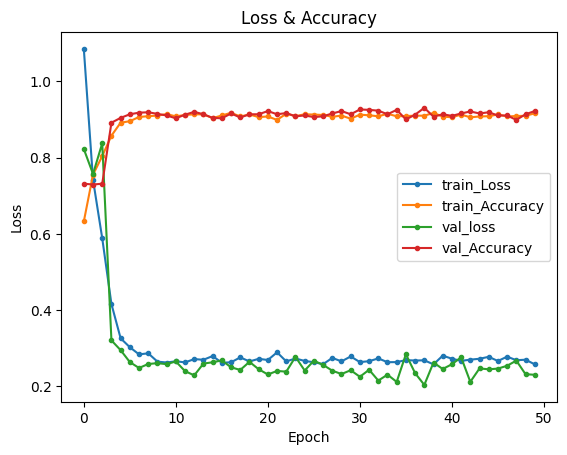

In [17]:
import matplotlib.pyplot as plt

plt.plot(losses, marker='.')  # 圆形标记
plt.plot(acces,marker='.')
plt.plot(val_ls,marker='.')
plt.plot(val_acc,marker='.')
plt.title("Loss & Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train_Loss', 'train_Accuracy', 'val_loss', 'val_Accuracy'])  # 更新图例

plt.show()

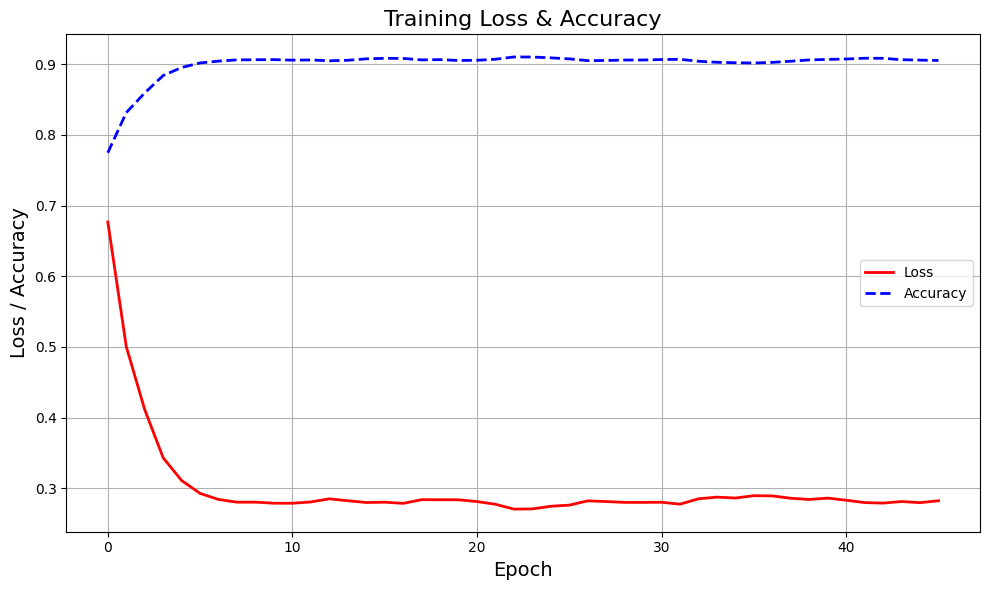

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# 移动平均函数
def smooth_curve(values, window_size=5):
    return np.convolve(values, np.ones(window_size)/window_size, mode='valid')

# 假设 losses 和 acces 是你的损失和准确率列表
smoothed_losses = smooth_curve(losses)
smoothed_acces = smooth_curve(acces)

# 绘制平滑后的损失和准确率曲线
plt.figure(figsize=(10, 6))

# 绘制损失曲线
plt.plot(smoothed_losses, label='Loss', color='red', linestyle='-', linewidth=2)

# 绘制准确率曲线
plt.plot(smoothed_acces, label='Accuracy', color='blue', linestyle='--', linewidth=2)

# 设置标题和标签
plt.title("Training Loss & Accuracy", fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss / Accuracy', fontsize=14)

# 显示图例
plt.legend()

# 优化图形的显示
plt.grid(True)
plt.tight_layout()

# 显示图像
plt.show()


NameError: name 'model' is not defined